# Demo Quark

Aleksandr Suvorov

6.01.2023

---

[CardioQuark](https://www.cardioqvark.ru/) is a panel installed on IPhone which has sensors for patients` fingers.

CardioQuark can read some parameters like patients` 1-channel ECG. Various algorithms are then used to extract single complex and analyse time intervals.
This primer is dedicated to classification task: our goal is to find diastolic disfunction in patient. Usually this parameter is assessed whith cardiac ultrasound. 

Dataset can be downloaded here: [Quark dataset](https://drive.google.com/file/d/1DE1njl3M7y5NfFCd04SX0IegtaG09EyN/view?usp=share_link)

The main task is to predict [0, 1] classes (absense or presence of diastolic dysfunction in patient).

Next steps consider simple data preprocessing, building a Lasso-classifier and building neural network classifier with PyTorch.

More complex version of the classifier is [registered as proprietary software](https://fips.ru/publication-web/publications/document?type=doc&tab=PrEVM&id=32E41B1D-4CF5-44D2-88CA-103704C8FC5B) or [link](https://www1.fips.ru/ofpstorage/Doc/PrEVM/RUNWPR/000/002/022/680/844/2022680844-00001/DOCUMENT.PDF).

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import joblib

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
warnings.filterwarnings("ignore")

In [36]:
## Global constants

# Random state
RS = 101 
SELECTED_VARS_LEN = 10

## Import data

Data is a `pandas` dataframe `Quark_diast_data_06_01_2023.pkl` where we have some patients history parameters (Age, Sex, Diabetus mellitus, Smoking history) and large amount of data about one-channel ECG features.

There are some few categorical variables in the dataframe, others are numerical.

In [37]:
# Load data
df = pd.read_pickle('../data/01_raw_data/data.pkl')

# Split data for test / train
X = df.drop('Y_diast', 1)
Y = df['Y_diast']

# Create lists with numeric and categorical columns
category_cols = [col for col in X.columns if X[col].dtype == 'category']
numeric_cols = [col for col in X.columns if col not in category_cols]

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RS)

# Printing information about classes in target variables for train/test:
print('Target parameters: \n')
for target, name in zip([y_train, y_test], ['TRAIN', 'VALIDATION']):
    print(f'- {name} size is {len(target)} with {int(target.astype(float).sum())} targets which is {int(target.astype(float).sum() / len(target)*100)}%')

# Printing information about train dataset:
print(f'\nThere are {len(X_train.columns)} columns in the sets')

Target parameters: 

- TRAIN size is 347 with 108 targets which is 31%
- VALIDATION size is 149 with 47 targets which is 31%

There are 50 columns in the sets


## Resampling training set

Since we have unbalanced target rate in training set and we do not know the further rate in test data I want to make a resampled training set with target ratio 1:1 and the total size of training data should consist of 500 patients.

In [38]:
from sklearn.utils import resample

target_0_df = X_train.loc[y_train[y_train == 0].index, :]
target_1_df = X_train.loc[y_train[y_train == 1].index, :]

# Create resampled dataset with 500 patients and 1:1 target classes 
X_train_res = pd.concat([
    resample(target_0_df, n_samples = 250, random_state = RS),
    resample(target_1_df, n_samples = 250, random_state = RS)
])

y_train_res = np.hstack([np.zeros(250), np.ones(250)])

## Part 1. Lasso classifier

### Feature selection with Lasso classifier

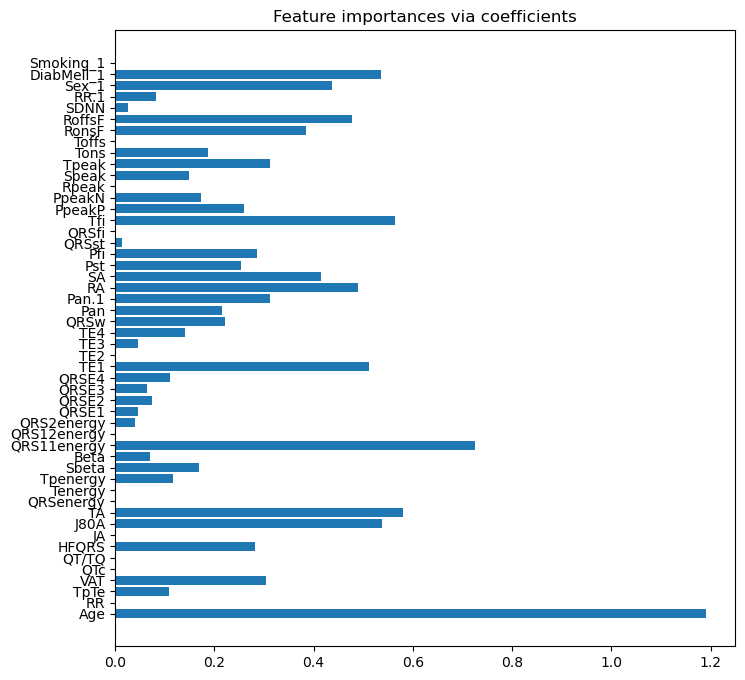

['Age', 'QRS11energy', 'TA', 'Tfi', 'J80A', 'DiabMell_1', 'TE1', 'RA', 'RoffsF', 'Sex_1', 'SA', 'RonsF', 'Tpeak', 'Pan.1', 'VAT', 'Pfi', 'HFQRS', 'PpeakP', 'Pst', 'QRSw', 'Pan', 'Tons', 'PpeakN', 'Sbeta', 'Speak']


In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV

# Create `preprocessor` pipeline for data preprocessing
# Imputing, scaling, one-hot-encoding

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
                            ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
            handle_unknown='ignore', 
            drop = 'if_binary',
            sparse = False))
])

preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_cols),
                ("cat", categorical_transformer, category_cols)
                ],
                remainder='passthrough'
                )

# Creating LassoCV classifier for feature selection
# Next we obtain the absolute coefficients from LassoCV and get top-10 features

clf = LogisticRegressionCV(Cs=np.logspace(-15, 15, num=25),
    penalty = 'l1',
    solver = 'saga',
    cv = 10, 
    random_state = RS)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", clf)
    ])

pipe.fit(X_train_res, y_train_res)

importance = np.abs(pipe[-1].coef_)[0]
features = [f.replace("num__", "").replace("cat__", "") for f \
    in pipe[:-1].get_feature_names_out()]

figure = plt.figure(figsize = (8, 8))
plt.barh(features, importance)
plt.title("Feature importances via coefficients")
plt.show()

selected = [x[0] for x in sorted({k:v for k, v in \
    zip(features, importance)}.items(), \
        key=lambda x: x[1], reverse=True)][:25]

print(selected)

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
                            ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
            handle_unknown='ignore', 
            drop = 'if_binary',
            sparse = False))
])

preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_cols),
                ("cat", categorical_transformer, category_cols)
                ],
                remainder='passthrough'
                )

pd.DataFrame(preprocessor.fit_transform(X_train_res))

features = [f.replace("num__", "").replace("cat__", "") for f \
    in pipe[:-1].get_feature_names_out()]



In [ ]:
X_train_res.iloc[train_index, :]

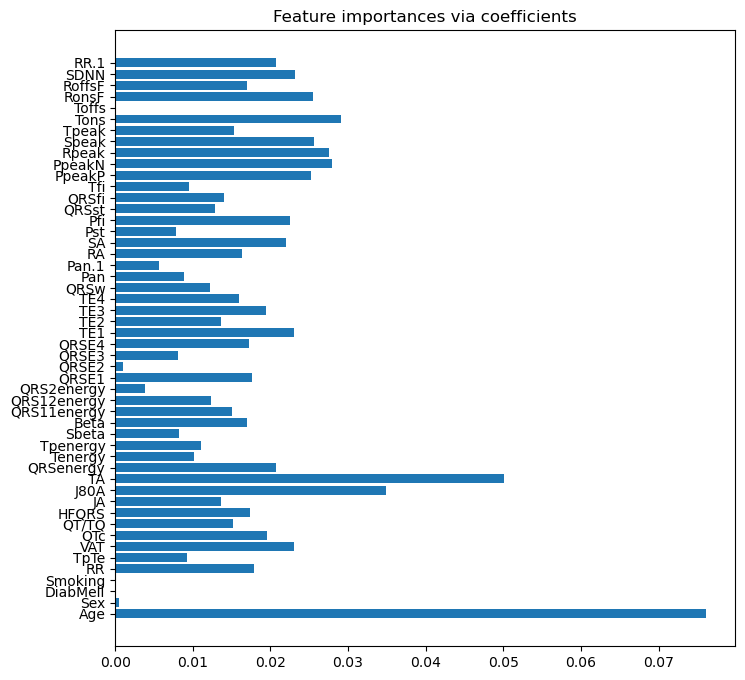

['Age', 'TA', 'J80A', 'Tons', 'PpeakN', 'Rpeak', 'Speak', 'RonsF', 'PpeakP', 'SDNN', 'TE1', 'VAT', 'Pfi', 'SA', 'QRSenergy', 'RR.1', 'QTc', 'TE3', 'RR', 'QRSE1', 'HFQRS', 'QRSE4', 'Beta', 'RoffsF', 'RA']


In [71]:
from sklearn.model_selection import ShuffleSplit
from xgboost import XGBClassifier

rs = ShuffleSplit(n_splits=10, train_size=.5, random_state=RS)

clf = XGBClassifier(
    n_estimators = 10,
    random_state = RS,
    tree_method = 'hist',
    n_jobs = -1, 
    enable_categorical = True
    )

importance = []

for train_index, _ in rs.split(X_train_res):
    clf.fit(
        X_train_res.iloc[train_index, :],
        y_train_res[train_index]
    )
    importance = importance + [[clf.feature_importances_]]

features = X_train_res.columns
importance = np.median(np.array(importance).reshape(-1, len(features)), axis = 0)

figure = plt.figure(figsize = (8, 8))
plt.barh(features, importance)
plt.title("Feature importances via coefficients")
plt.show()

selected = [x[0] for x in sorted({k:v for k, v in \
    zip(features, importance)}.items(), \
        key=lambda x: x[1], reverse=True)][:25]

print(selected)

In [62]:
np.median(np.array(importance).reshape(-1, 50), axis = 0)


array([0.09211598, 0.01444892, 0.        , 0.0113555 , 0.01404299,
       0.00880748, 0.02088574, 0.02416677, 0.0170081 , 0.02096175,
       0.01465407, 0.02956065, 0.03778822, 0.03351999, 0.00257155,
       0.01199539, 0.01049139, 0.03390625, 0.01478805, 0.018366  ,
       0.00252589, 0.01801087, 0.01376383, 0.00925311, 0.02393111,
       0.02031605, 0.02292114, 0.03959137, 0.00393644, 0.02081391,
       0.00486012, 0.01116161, 0.01712885, 0.02708571, 0.01386721,
       0.02034454, 0.0156032 , 0.0060921 , 0.00865545, 0.02359729,
       0.02047387, 0.04073549, 0.02913076, 0.01474865, 0.04412417,
       0.        , 0.04313953, 0.00631763, 0.02307608, 0.02335917],
      dtype=float32)

In [252]:
selected = ['TE1', 'Age', 'J80A', 'DiabMell', 'QTc', 'RonsF', 'QRSE1', 'Pan', 'JA', 'Sex', 'RoffsF', 'Speak', 'TA', 'PpeakP', 'RR.1', 'Smoking', 'Pfi', 'Tons', 'HFQRS', 'QRS11energy', 'Beta', 'TpTe', 'TE4', 'Tpenergy', 'QRSst']
selected = selected[0:SELECTED_VARS_LEN]

X_train = X_train[selected]
X_test = X_test[selected]

target_0_df = X_train.loc[y_train[y_train == 0].index, :]
target_1_df = X_train.loc[y_train[y_train == 1].index, :]

# Create resampled dataset with 500 patients and 1:1 target classes 
X_train_res = pd.concat([
    resample(target_0_df, n_samples = 250, random_state = RS),
    resample(target_1_df, n_samples = 250, random_state = RS)
])

y_train_res = np.hstack([np.zeros(250), np.ones(250)])

y_train = pd.Series(y_train_res, index = X_train_res.index)

train_index = [str(x) + 'train' for x in range(len(X_train_res.index))]
test_index = [str(x) + 'test' for x in X_test.index]

y_train.index = train_index
y_test.index = test_index

In [253]:
category_cols = [col for col in X_train_res.columns if X_train_res[col].dtype == 'category']
numeric_cols = [col for col in X_train_res.columns if col not in category_cols]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
                            ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
            handle_unknown='ignore', 
            drop = 'if_binary',
            sparse = False))
])

preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_cols),
                ("cat", categorical_transformer, category_cols)
                ],
                remainder='passthrough'
                )

X_train_res = pd.DataFrame(preprocessor.fit_transform(X_train_res))
X_test = pd.DataFrame(preprocessor.transform(X_test))

colnames = [list(y.get_feature_names_out()) for x,y in preprocessor.named_transformers_.items()]

colnames = list(itertools.chain(*colnames))

X_train_res.columns = colnames
X_test.columns = colnames

X_train_res.index = train_index
X_test.index = test_index

In [254]:
X_full = pd.concat([
    X_train_res,
    X_test
    ])

y_full = pd.concat([
    y_train,
    y_test
])

In [255]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sma 
import networkx as nx

from sklearn.preprocessing import StandardScaler
from seaborn import palettes
from itertools import combinations
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from numpy import linalg as LA
warnings.filterwarnings("ignore")

from sklearn.linear_model import SGDClassifier


class DataFrameLoader(object):

    def __init__(
            self
        )-> None:
        pass     

    def fit(self, data: pd.core.frame.DataFrame):
        self.data = data
        self.nodes_lst = data.columns
        self.edges_lst = [i for i in list(combinations(self.nodes_lst, r = 2))]


class Snltc(object):

    def __init__(self):
        pass


    def fit(self, data, labels, clf=None):



        dfl = DataFrameLoader()
        self.data = data
        dfl.fit(self.data)
        
        self.nodes_lst = dfl.nodes_lst
        self.edges_lst = dfl.edges_lst
        self.labels = labels

        model_lst = []

        for i in self.edges_lst: 
            if clf:
                clf = clf
            else:
                clf = SVC(probability = True, random_state=RS)
                # clf = SGDClassifier(random_state = RS,
                #     n_jobs = -1,
                #     loss='huber')

            model_lst = model_lst + [clf.fit(self.data[[i[0], i[1]]], self.labels)]
        self._model_lst = model_lst


    def transform(self, newdata, newindex=None):      

        new_dfl = DataFrameLoader()
        self.newdata = newdata

        new_dfl.fit(self.newdata)
        
        self.new_nodes_lst = new_dfl.nodes_lst
        self.new_edges_lst = new_dfl.edges_lst

        assert self.new_nodes_lst.all() == self.nodes_lst.all(), f"Train data and new data have different features-nodes"
        assert self.new_edges_lst == self.edges_lst, f"Train data and new data have different features-edges"

        del self.new_nodes_lst
        del self.new_edges_lst

        _new_epsilons = np.array([])
        
        for i, model in zip(self.edges_lst, self._model_lst): 
            # print(self.newdata[[i[0], i[1]]])
            _new_epsilons = np.hstack([_new_epsilons, 
                np.array(model.predict_proba(self.newdata[[i[0], i[1]]])[:,1])])
                # np.array(model.predict(self.newdata[[i[0], i[1]]]))])
        
        self.new_epsilons = _new_epsilons.reshape(len(self._model_lst), 
            int(len(_new_epsilons)/len(self._model_lst))).T

        if newindex:
            self.index = newindex
        else:
            self.index = np.array(range(self.new_epsilons.shape[0]))


    def ntwrk_construct(self, type = 'thres'):

        self.graphs = dict()

        if type == 'weighted':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    G.add_edge(edge[0], edge[1], weight = self.new_epsilons[index, position])

                self.graphs[self.index] = G

        elif type == 'thres':

            for index, s_idx in zip([x for x in range(len(self.index))], [x for x in self.index]):              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    # print(float(self.new_epsilons[index, position]))
                    if float(self.new_epsilons[index, position]) > .4:
                        G.add_edge(edge[0], edge[1])

                self.graphs[s_idx] = G

        elif type == 'weighted_thres':

            for index, s_idx in zip([x for x in range(len(self.index))], [x for x in self.index]):              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    if float(self.new_epsilons[index, position]) > .4:
                        G.add_edge(edge[0], edge[1], weight = float(self.new_epsilons[index, position]))
                    else:
                        G.add_edge(edge[0], edge[1], weight = 0)

                self.graphs[s_idx] = G

        else:
            raise KeyboardError('Type must be `weighted`, `thres` or `weighted_thres`')

In [256]:
from sklearn.svm import SVC

snc = Snltc()

snc.fit(X_train_res, y_train)

snc.transform(X_full, newindex=list(X_full.index))

snc.ntwrk_construct(type = 'weighted_thres')

In [257]:
XY_g = pd.DataFrame(
    dict(
        idx = list(snc.graphs.keys()),
        Matrices = [nx.to_numpy_array(x) for x in list(snc.graphs.values())]
    )
)

XY_g.index = list(snc.graphs.keys())

XY_full = XY_g.merge(pd.DataFrame(y_full), left_index=True, right_index=True)
XY_full = XY_full.drop('idx', 1)

XY_full.columns = ['Matrices', 'Group']

XY_train = XY_full.loc[[x for x in XY_full.index if 'train' in x],:]
XY_test = XY_full.loc[[x for x in XY_full.index if 'test' in x],:]

X_train, X_test = [x.drop('Group', 1) for x in [XY_train, XY_test]]
y_train, y_test = [x['Group'] for x in [XY_train, XY_test]]

In [258]:
XY_full.head()

,Matrices,Group
0train,"[[0.0, 0.5936943866824879, 0.5197161566782752,...",0.0
1train,"[[0.0, 0.4697069458228128, 0.4937022319349778,...",0.0
2train,"[[0.0, 0.5, 0.45811545778319224, 0.45248449974...",0.0
3train,"[[0.0, 0.5249823274980814, 0.4100925799011132,...",0.0
4train,"[[0.0, 0.45146362675227036, 0.5134108034461438...",0.0


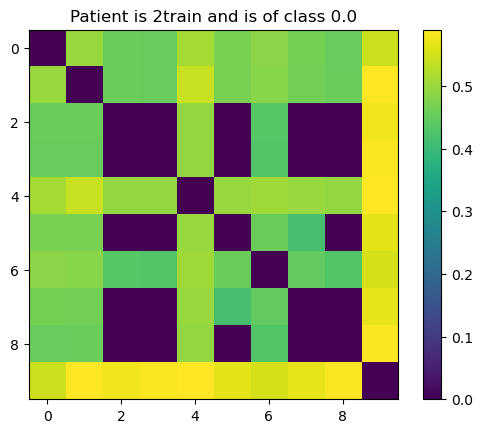

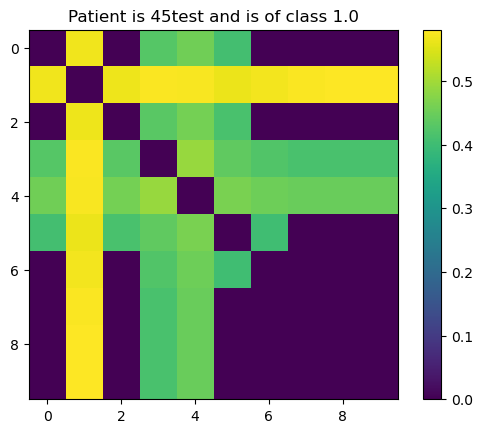

In [259]:
for patient in ['2train', '45test']:

    M = XY_full.loc[patient, 'Matrices']

    plt.imshow(M)
    plt.colorbar()
    plt.title(f'Patient is {patient} and is of class {XY_full.loc[patient, "Group"]}')
    plt.show()

In [260]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/guest/Документы/medstats/Python_scripts')

import ModPerf as mdp
from importlib import reload

In [261]:
X_train, X_test = [torch.FloatTensor(x) for x in \
    [X_train['Matrices'], X_test['Matrices']]]
y_train, y_test = [torch.LongTensor(x) for x in [y_train.astype(int), y_test.astype(int)]]

X_train = torch.reshape(X_train, (-1, 1, SELECTED_VARS_LEN, SELECTED_VARS_LEN))
X_test = torch.reshape(X_test, (-1, 1, SELECTED_VARS_LEN, SELECTED_VARS_LEN))

In [264]:
# Defining CNN...

def init_weights(self):
    for module in self.modules():
        if (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear)):
            nn.init.xavier_uniform(module.weight)
            module.bias.data.fill_(0.01)

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, 1, 2)
#         self.conv2 = nn.Conv2d(32, 32, 3, 1, 2)
#         self.conv2_drop = nn.Dropout2d(.5)
#         self.bnm1 = nn.BatchNorm1d(128, momentum=0.1)    
#         self.fc1 = nn.Linear(128, 128)
#         self.bnm2 = nn.BatchNorm1d(128, momentum=0.1)
#         self.fc2 = nn.Linear(128, 64)
#         self.bnm3 = nn.BatchNorm1d(64, momentum=0.1)
#         self.fc3 = nn.Linear(64, 32)
#         self.fc4 = nn.Linear(32, 2)

class Net(nn.Module):
    def __init__(self, kernel_size, input_dims):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size, 1, 2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size, 1, 2)
        self.conv2_drop = nn.Dropout2d(.5)
        self.bnm1 = nn.BatchNorm1d(input_dims, momentum=0.1)    
        self.fc1 = nn.Linear(input_dims, 128)
        self.bnm2 = nn.BatchNorm1d(128, momentum=0.1)
        self.fc2 = nn.Linear(128, 64)
        self.bnm3 = nn.BatchNorm1d(64, momentum=0.1)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 3)
        x = F.max_pool2d(self.conv2_drop(self.conv2(x)), 3)
        x = x.view(x.size(0), -1)
        x = F.relu(F.dropout(self.fc1(self.bnm1(x)), 0.4))
        x = F.relu(F.dropout(self.fc2(self.bnm2(x)), 0.4))
        x = F.relu(F.dropout(self.fc3(self.bnm3(x)), 0.4))
        x = self.fc4(x)
        return F.log_softmax(x)

# Defining hyperparameters

learning_rate = 0.0001
n_epochs = 10
batch_size = 32

# Loading data

train_loader = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train),
  batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    TensorDataset(X_test, y_test),
  batch_size=batch_size, shuffle=True)

# Calculationg loss

loss_per_epoch_train = []
loss_per_epoch_val = []

torch.manual_seed(RS)
network = Net(3, 128)
network.apply(init_weights)

loss_fn=nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

early_stop_thres = 10
early_stop_counter = 0

for epoch in range(n_epochs):

    loss_per_batch_train = []
    loss_per_batch_val = []

    for x, y in train_loader:          
    
        optimizer.zero_grad()
        pred = network(x)
        loss=loss_fn(pred, y)
        loss_per_batch_train = loss_per_batch_train + [loss.item()]
        loss.backward()
        optimizer.step()

    loss_per_epoch_train = loss_per_epoch_train + [np.array(loss_per_batch_train).mean()]

    network.eval()

    for x, y in val_loader:

        pred_val = network(x)
        loss_eval=loss_fn(pred_val, y)
        loss_per_batch_val = loss_per_batch_val + [loss_eval.item()]

    last_epoch = epoch

    last_loss = np.array(loss_per_batch_val).mean()
    if len(loss_per_epoch_val) > 0:
        max_loss = max(loss_per_epoch_val)
    else:
        max_loss = 0
    loss_per_epoch_val = loss_per_epoch_val + [last_loss]  

    if last_loss > max_loss:
        early_stop_counter += 1
        if early_stop_counter == early_stop_thres:

            break

# torch.save(model, 'model.pth')

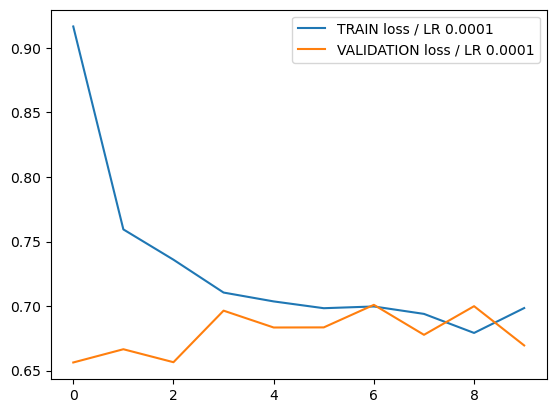

Test data ROC AUC score: 0.47641509433962265

Inverted class!


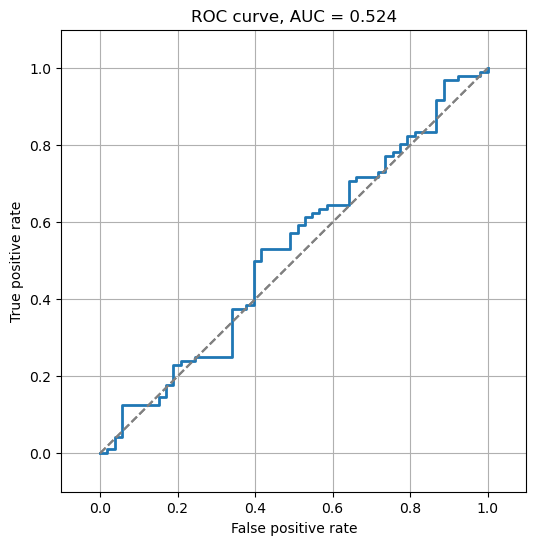

In [214]:
# Plotting loss curves

save_name ='Model_' + str(1)

fig = plt.figure()
plt.plot(
    np.array(range(last_epoch + 1)),
    np.array(loss_per_epoch_train),
    label = f'TRAIN loss / LR {learning_rate}'
    )
plt.legend()

plt.plot(
    np.array(range(last_epoch + 1)),
    np.array(loss_per_epoch_val),
    label = f'VALIDATION loss / LR {learning_rate}'
    )
plt.legend()
plt.show()
fig.savefig(save_name + '_LOSS.png', facecolor='white', transparent=False)

# Let`s plot the ROC - curve

y_pred = torch.sigmoid(network(X_test)).detach().numpy()[:,1]
print(f'Test data ROC AUC score: {roc_auc_score(y_test.detach().numpy(), y_pred)}\n')

mdp.ROCPlotter_Binary(
    y_test.detach().numpy(), 
    y_pred,
    save_name=save_name
    )